### 소스코드

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.linear_model import QuantileRegressor, LinearRegression

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.mixture import GaussianMixture

sns.set_theme(style="darkgrid", font_scale=1.6)

K = 1_000
M = 1_000_000
# ID,Message Size,Sending Rate,RTT,Latency
# ,Method,Quantile,Latency,Estimated Latency,Overhead,Historical Data Size
data_col = {
    'i': 'ID',
    'm': 'Message Size',
    's': 'Sending Rate',
    'r': 'RTT',
    'l': 'Latency',
    'l_pred': 'Estimated Latency',
    's_d': 'Serialization Delay',
    'c_d': 'Combination Delay',
    'ma_s': 'Moving Av. Sending Rate',
    'ma_r': 'Moving Av. RTT',
}

eval_col = {
    'm': 'Method',
    'q': 'Quantile',
    'l': 'Latency',
    'l_pred': 'Estimated Latency',
    'o': 'Overhead',
    'msg': 'Message Size',
    'ft': 'feature',
    'r_o': 'Relative Overhead',
    'h': 'Historical Data Size',
    's': 'Success Rate',
    'q_loss': 'Quantile Loss',
    'e': 'Error',
    'ae': 'Absolute Error',
    'mae': 'MAE',
    'f': "Failure Rate",
    'p': "Update Period",
    'qe': "Quantile Error"
}

unit = {
    'm' : " (MB)",
    's' : " (MB/s)",
    'l' : " (ms)",
    'r' : " (ms)",
    'h' : " (KB)",
    'o' : " (ms)",
    "r_o": " (%)",
    's_d': " (ms)",
    "c_d": " (ms)",
    'ma_s': ' (MB/s)',
    'ma_r': ' (ms)',
    'ms': " (ms)",
    'KB': " (KB)",
    "MBps": " (MB/s)",
    'mae': " (ms)",
    'f': " (%)",
    'q_loss': " (ms)",
}

def data_col_by_keys(keys):
    return [data_col[key] for key in keys]

def eval_col_by_keys(keys):
    return [eval_col[key] for key in keys]

def label_unit(key, eval = True):
    return eval_col[key] + unit[key] if eval_col else data_col[key] + unit[key]

def preproc(df_origin):
    col_i, col_m, col_s, col_r, col_l, col_s_d, col_c_d = data_col_by_keys(['i', 'm', 's', 'r', 'l', 's_d', 'c_d'])
    # sort the dataframe by message id
    df = df_origin[[col_i, col_m, col_s, col_r, col_l]].sort_values(data_col['i'])

    # features
    # Message Size : B -> MB
    # Sending rate : B/s -> MB/s
    # RTT : micro sec -> ms
    df[col_m] = df[col_m] / M
    df[col_s] = df[col_s] / M
    df[col_r] = df[col_r] / K
    # latency : micro sec -> ms
    df[col_l] = df[col_l] / K

    df[col_s_d] = (df[col_m] / df[col_s]) * K
    df[col_c_d] = df[col_s_d] + df[col_r]

    return df

# def moving_average(df,window_size=10):
#     col_m, col_s, col_r, col_ma_s, col_ma_r, col_s_d, col_c_d = data_col_by_keys(['m','s', 'r', 'ma_s', 'ma_r', 's_d', 'c_d'])

#     df[col_ma_r] = df[col_r].rolling(window_size).mean()
#     df[col_ma_s] = df[col_s].rolling(window_size).mean()

#     df[col_s_d] = (df[col_m] / df[col_ma_s]) * K
#     df[col_c_d] = df[col_s_d] + df[col_ma_r]


# 그룹화
def calculate_mid_results(df_list):
  for df in df_list:
    c_l, c_l_pred = data_col_by_keys(['l', 'l_pred'])
    c_e, c_mae, c_q, c_q_loss, c_o, c_r_o, c_s= eval_col_by_keys(['e', 'mae', 'q', 'q_loss', 'o', 'r_o', 's'])

    # 에러 계산
    df[c_e] = df[c_l] - df[c_l_pred]
    df[c_mae] = np.abs(df[c_e])

    df[c_q_loss] = df.apply(
      lambda row: ((1-row[c_q]) * row[c_mae] if row[c_e] < 0 else row[c_q] * row[c_mae]), axis=1
    )

    df[c_r_o] = (df[c_o] / df[c_l]) * 100 # 퍼센트
    df[c_s] = (df[c_l] <= df[c_l_pred]) * 100

def evaluate(df):
  eval = df[eval_col_by_keys(['m', 'q', 's', 'mae', 'q_loss', 'o', 'r_o'])].groupby(by=eval_col_by_keys(['m', 'q'])).mean()
  return eval.reset_index()

def group_count(df):
  df.loc[:, 'count'] = 0
  return df[eval_col_by_keys(['m', 'q'])+['count']].groupby(by=eval_col_by_keys(['m', 'q'])).count()

def evaluate_valid_prediction(df):
  # 예측된 경우와 예측 자체를 실패한 경우 나눈다
  df_correct = df[df[data_col['l_pred']] > 0]
  df_fail = df[df[data_col['l_pred']] < 0]

  # 예측된 경우만 성능 평가를 하고
  calculate_mid_results([df_correct])
  df_correct_group = evaluate(df_correct)

  # 예측 실패 비율을 구하여 합친다
  merged_data = pd.merge(
      group_count(df_fail),
      group_count(df),
      on=eval_col_by_keys(['m', 'q']),
      suffixes=('_1', '_2')
  )
  merged_data['Failure Rate'] = np.round((merged_data['count_1'] / merged_data['count_2']),3)

  group = df_correct_group.merge(
      merged_data,
      on=eval_col_by_keys(['m', 'q']),
      how='left'
  )
  group.fillna(0, inplace=True)
  group = group.reset_index()
  return group

In [95]:
c_mae, c_m, c_e, c_ae, c_q, c_q_loss, c_o, c_r_o, c_s, c_h = eval_col_by_keys(['mae', 'm', 'e', 'ae', 'q', 'q_loss', 'o', 'r_o', 's', 'h'])

sns.set_theme(style="darkgrid", font_scale=2)

color_s = '#006400'
color_mae = "#FF8C00"
color_q_loss = "#d62728"
color_o = "#1f77b4"
palette = {"success rate": "#2ca02c", "mae": "#ff7f0e", "quantile loss": "#d62728", "overhead": "#1f77b4"}


class Visualization:
    def __init__(self):
        None

    # 1. 전송률의 변화
    def change_over_time(self, savefile, df, y, y_limit, lim=200):
      id, feature, l = data_col_by_keys(['i', y, 'l'])

      f, ax1 = plt.subplots(figsize=(20, 8))
      sns.lineplot(df[: lim], x=id, y=feature, ax=ax1, label=feature)
      sns.lineplot(df[: lim], x=id, y='Latency', ax=ax1, label='Latency')
      plt.axhline(y_limit, color='black', linestyle='--')
      ax1.set_xlabel('Message ID')
      ax1.set_ylabel(feature + unit[y])

      plt.savefig(savefile, format='pdf', bbox_inches='tight')
      plt.show()

    # 2. 마진 분포와 선형 회귀
    def jointplot_latency(self, savefile, df, f,step=5):
      feature = data_col[f]
      latency = data_col['l']

      sns.jointplot(df[10::step], x=feature, y=latency,
                  kind="reg", truncate=False, height=7)
      plt.xlabel(feature + unit[f])
      plt.ylabel(latency + unit['l'])

      plt.savefig(savefile, format='pdf', bbox_inches='tight')
      plt.show()

    # 3. 히스토리컬 크기의 영향
    # 3-1. 성공률
    def over_data_size(self, savefile, df_group, x, y1, y2, color1, color2, y1_lim=None, y2_lim=None):
      c_x, c_y1, c_y2 = eval_col_by_keys([x, y1, y2])
      fig, ax1 = plt.subplots()

      ax1.set_xlabel(c_x)
      ax1.set_ylabel(label_unit(y1), color=color1)
      sns.lineplot(df_group, x=c_x, y=c_y1, ax=ax1, color=color1, errorbar=None)
      ax1.tick_params(axis='y', labelcolor=color1)

      # 두 번째 Y 축 설정 (트윈 Y 축)
      ax2 = ax1.twinx()
      ax2.set_ylabel(label_unit(y2), color=color2)
      sns.lineplot(df_group, x=c_x, y=c_y2, ax=ax2, color=color2, errorbar=None)
      ax2.tick_params(axis='y', labelcolor=color2)

      if y1_lim is not None:
        ax1.set_ylim(y1_lim)

      if y2_lim is not None:
        ax2.set_ylim(y2_lim)

      plt.savefig(savefile, format='pdf', bbox_inches='tight')
      plt.show()

    # 4. 업데이트 주기
    def luk_diff_over_quantiles(self, savefile, df_group, use_failure_rate=False):
      c_q, c_qe, c_mae, c_q_loss, c_o = eval_col_by_keys(['q', 'qe', 'mae', 'q_loss', 'o'])
      plt.figure(figsize=(20, 12))

      g = sns.lineplot(df_group, x=c_q, y=c_qe, label=c_qe)
      g = sns.lineplot(df_group, x=c_q, y=c_mae, label=c_mae)
      g = sns.lineplot(df_group, x=c_q, y=c_q_loss, label=c_q_loss)
      g = sns.lineplot(df_group, x=c_q, y=c_o, label=c_o)

      plt.xlabel(c_q)
      plt.ylabel('Performance Difference')

      plt.ylim(-3, 3)

      g.legend(loc = 'upper left', fontsize="x-small") #, bbox_to_anchor = (1, 0.5), ncol = 1)
      plt.axhline(0, color='black', linestyle='--')

      plt.savefig(savefile, format='pdf', bbox_inches='tight')
      plt.show()

    # 5. 분위수에 따른 평가
    def quantile_err_over_quantiles(self, savefile, df_group, use_failure_rate=False):
      c_qe, c_f = eval_col_by_keys(['qe', 'f'])
      # plt.figure(figsize=(10, 6))

      g = None
      if use_failure_rate:
        g = sns.scatterplot(df_group, x=c_q, y=c_qe, hue=c_m, size=c_f, sizes=(20, 200), alpha=0.6)

      else:
        g = sns.lineplot(df_group, x=c_q, y=c_qe, hue= c_m)

      plt.xlabel(c_q)
      plt.ylabel(c_qe)

      plt.ylim(-0.2, 0.2)

      g.legend(loc = 'upper right', fontsize="x-small", bbox_to_anchor = (1, 0.5), ncol = 1)
      plt.axhline(0, color='black', linestyle='--')

      plt.savefig(savefile, format='pdf', bbox_inches='tight')
      plt.show()

    def over_quantiles(self, savefile, df_group, y, color, y_lim=None):
      c_y = eval_col[y]

      # plt.figure(figsize=(20, 10))
      g = sns.lineplot(data = df_group, x=c_q, y=c_y, hue=c_m, color=color)
      plt.xlabel(c_q)
      plt.ylabel(label_unit(y))
      if y_lim is not None:
        plt.ylim(y_lim)

      g.legend(loc = 'upper right', fontsize="small") #, bbox_to_anchor = (1, 0.5), ncol = 1)

      plt.savefig(savefile, format='pdf', bbox_inches='tight')
      plt.show()

    def err_distibution(self, savefile, df, xlim=(-1000,300)):
      c_e = eval_col['e']
      plt.figure(figsize=(12, 14))
      sns.set_theme(style="whitegrid", font_scale=2)
      sns.histplot(data=df, x=c_e, hue=c_m, kde=True)

      plt.xlabel("Error (ms)")
      plt.xlim(xlim)
      plt.axvline(0, color='black', linestyle='--')


      plt.savefig(savefile, format='pdf', bbox_inches='tight')
      plt.show()


    def ecdf(self, savefile, df, q=0.99, xlim=(-1000,300)):
      c_e = eval_col['e']
      sns.set_theme(style="whitegrid", font_scale=2)
      plt.figure(figsize=(12, 14))
      sns.ecdfplot(df, x=c_e, hue=c_m)

      plt.xlabel("Error (ms)")
      plt.xlim(xlim)
      plt.axhline(q, color='red', linestyle='--')
      plt.axvline(0, color='black', linestyle='--')

      plt.savefig(savefile, format='pdf', bbox_inches='tight')
      plt.show()

    def barplot(self, savefile, df, y):
      c_x, c_y = eval_col_by_keys(['m', y])
      sns.set_theme(style="whitegrid", font_scale=1.8)
      plt.figure(figsize=(12, 12))

      x_label = ''
      y_label = label_unit(y)

      if y == 's':
        c_y = c_x
        c_x = 'Success Rate - Percentile'
        df[c_x] = df['Success Rate'] - df['Quantile'] * 100
        x_label = c_x
        y_label = ''

      g = sns.catplot(
          data=df, kind="bar",
          x=c_x, y=c_y, hue="Quantile",
          errorbar="sd", palette="dark", alpha=.6, height=6
      )
      plt.xlabel(x_label)
      plt.ylabel(y_label)

      plt.savefig(savefile, format='pdf', bbox_inches='tight')
      plt.show()

    # def barplot(self, savefile, df, y):
    #   c_y = eval_col[y]
    #   sns.set_theme(style="whitegrid", font_scale=1.6)
    #   plt.figure(figsize=(12, 12))

    #   if y == 's':
    #     c_y = 'Percentile - Success Rate'
    #     df[c_y] = df['Success Rate'] - df['Quantile'] * 100
    #     plt.ylabel(c_y)
    #   else:
    #     plt.ylabel(label_unit(y))

    #   g = sns.catplot(
    #       data=df, kind="bar",
    #       x="Method", y=c_y, hue="Quantile",
    #       errorbar="sd", palette="dark", alpha=.6, height=6
    #   )
    #   plt.xlabel('')

    #   plt.savefig(savefile, format='pdf', bbox_inches='tight')
    #   plt.show()

vis = Visualization()

# Set up
---

### Data Load and Processing

In [ ]:
root = "drive/MyDrive/thesis/results_tc/"
# Ethernet
# 1000mbit 6ms
m0 = preproc(pd.read_csv(root + "m0_500KB_3MB3.csv"))

#connection closed, recv=3242852 sent=7111356 lost=99944 retrans=100341 sent_bytes=9552687721 recv_bytes=167999396 lost_bytes=134785473

m2 = preproc(pd.read_csv(root + "m2_1KB.csv"))
m1 = preproc(pd.read_csv(root + "m1_3MB.csv"))

data = m1

In [ ]:
df = pd.read_csv(root + "m0_500KB_3MB3.csv")
m0.describe()

,ID,Message Size,Sending Rate,RTT,Latency,Serialization Delay,Combination Delay
count,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000
mean,2599.500000,1.753549,18.509997,56.789268,132.880340,193.208198,249.997466
std,1501.255031,0.720718,17.682522,98.483366,156.056077,1218.734569,1225.157200
min,0.000000,0.500290,0.032186,0.151000,3.156000,3.749766,5.324167
25%,1299.750000,1.134924,8.329845,4.620750,34.576000,65.106732,92.763104
50%,2599.500000,1.751327,13.670963,20.497000,81.824000,118.296490,160.024338
75%,3899.250000,2.382246,22.574598,64.761750,177.045750,210.577344,284.396222
max,5199.000000,2.999327,177.396943,1753.042000,2499.308000,84368.203567,84378.362567


### 전송률의 변화

In [ ]:
m0 = preproc(pd.read_csv(root + "m0_500KB_3MB3.csv"))
data = m0[500:]

# vis.change_over_time('sending_rate.pdf', m0, 's', 125, 1000)
vis.change_over_time('rtt.pdf', data, 'r', 6, 100)

data = m0
# vis.jointplot_latency('message_size_latency.pdf', data, 'm', 1)
# vis.jointplot_latency('serialization_delay_latency.pdf', data[data['Serialization Delay']<300], 's_d',1)
# vis.jointplot_latency('combination_delay_latency.pdf', data[data['Combination Delay']<300], 'c_d', 1)
# vis.jointplot_latency('rtt_latency.pdf', data[data['RTT']<50], 'r',5)

### 결과 파일

In [75]:
root = "drive/MyDrive/thesis/results_no_ma/"

<Figure size 1200x1200 with 0 Axes>

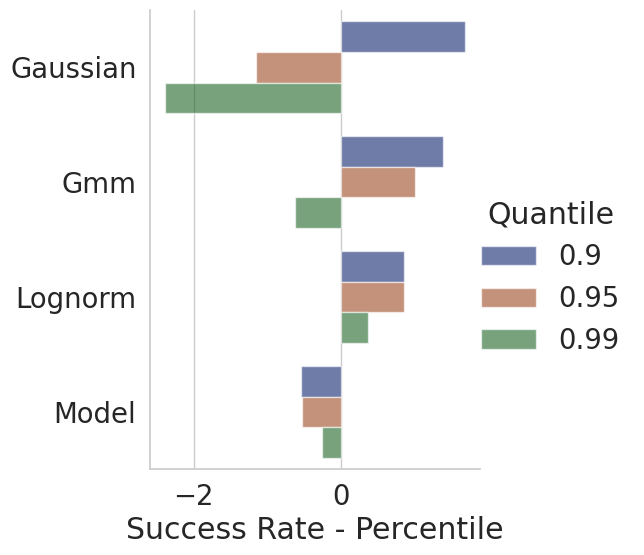

<Figure size 1200x1200 with 0 Axes>

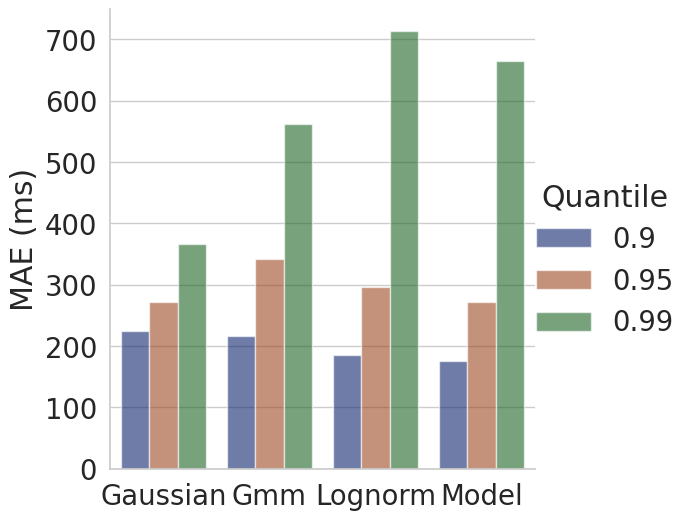

<Figure size 1200x1200 with 0 Axes>

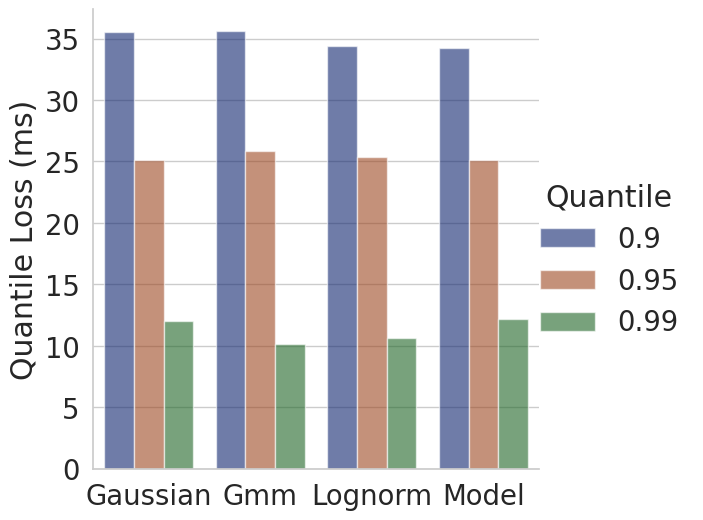

<Figure size 1200x1200 with 0 Axes>

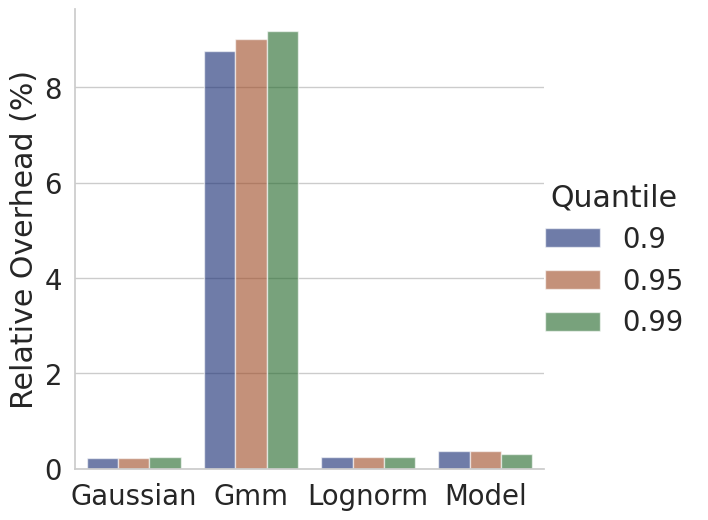

In [88]:
m0 = pd.concat([pd.read_csv(root + "m0_" + str(i)+'.csv') for i in [1,2,3,4]])
m0.loc[m0['Method']=='Quantile Reg', 'Method'] = 'Model'
calculate_mid_results([m0,])
m0_group = evaluate(m0)
vis.barplot('m0__success_rate.pdf', m0_group, 's')
vis.barplot('m0_mae.pdf', m0_group, 'mae')
vis.barplot('m0_q_loss.pdf', m0_group, 'q_loss')
vis.barplot('m0_r_overhead.pdf', m0_group, 'r_o')

In [70]:
m0_group[m0_group['Quantile']==0.99]

,Method,Quantile,Success Rate,MAE,Quantile Loss,Overhead,Relative Overhead,Success Rate - Percentile
2,Gaussian,0.99,95.494318,322.819048,13.297838,0.083444,0.227884,-3.505682
5,Gmm,0.99,97.244318,538.958202,11.716682,2.285778,6.010917,-1.755682
8,Lognorm,0.99,97.937500,491.872373,10.797047,0.090911,0.247906,-1.062500
11,Model,0.99,98.732955,612.293582,9.729685,0.119767,0.315786,-0.267045


<Figure size 1200x1200 with 0 Axes>

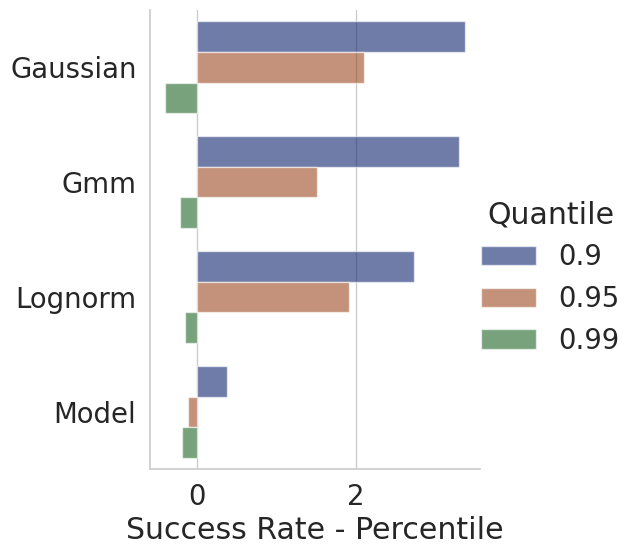

<Figure size 1200x1200 with 0 Axes>

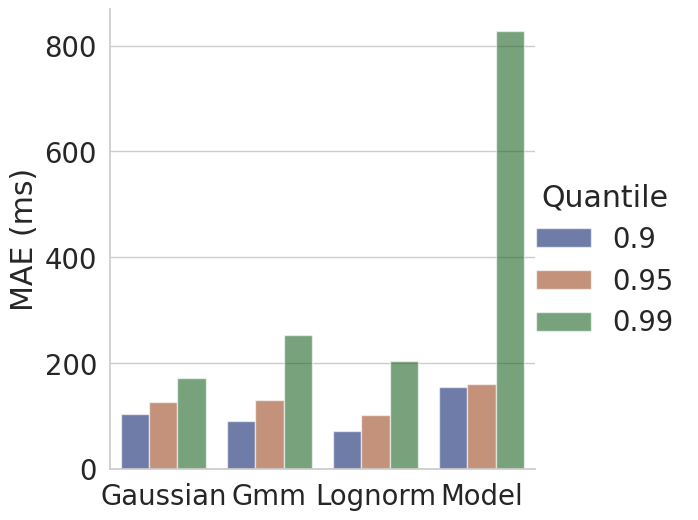

<Figure size 1200x1200 with 0 Axes>

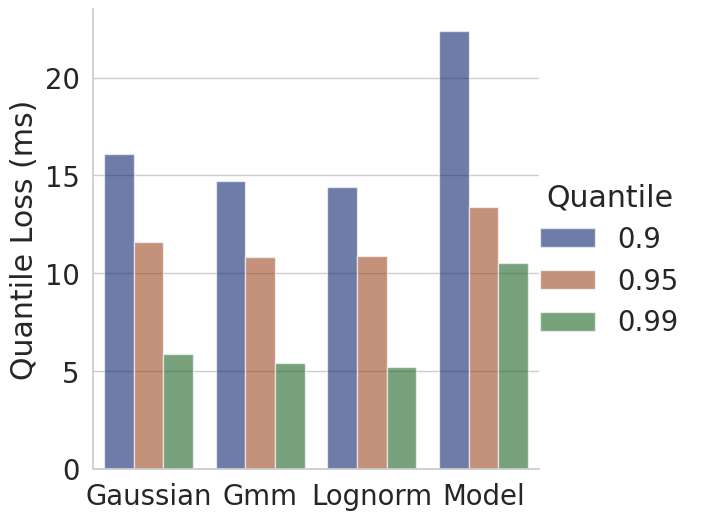

<Figure size 1200x1200 with 0 Axes>

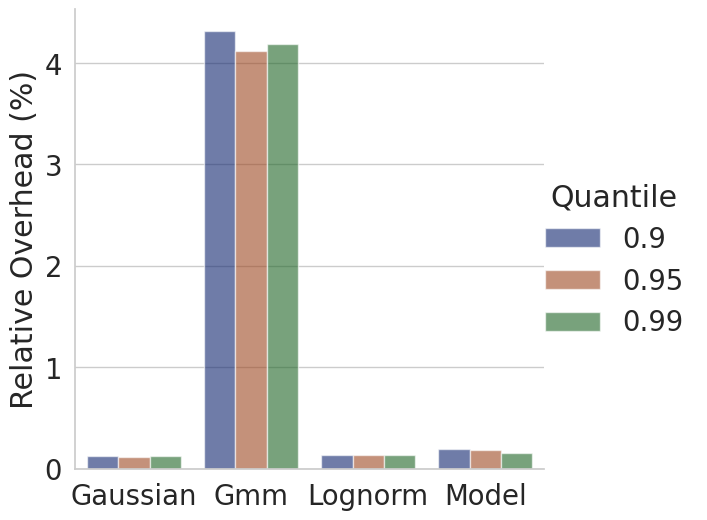

In [89]:
m1 = pd.concat([pd.read_csv(root + "m1_" + str(i)+'.csv') for i in [1,2,3,4]])
m1.loc[m1['Method']=='Quantile Reg', 'Method'] = 'Model'

calculate_mid_results([m1])
m1_group = evaluate(m1)

vis.barplot('m1_success_rate.pdf', m1_group, 's')
vis.barplot('m1_mae.pdf', m1_group, 'mae')
vis.barplot('m1_q_loss.pdf', m1_group, 'q_loss')
vis.barplot('m1_r_overhead.pdf', m1_group, 'r_o')

In [92]:
m1_group[m1_group['Quantile']==0.99]

,Method,Quantile,Success Rate,MAE,Quantile Loss,Overhead,Relative Overhead,Success Rate - Percentile
2,Gaussian,0.99,98.587719,172.136444,5.872199,0.096975,0.122670,-0.412281
5,Gmm,0.99,98.785088,252.997288,5.405108,3.324341,4.182457,-0.214912
8,Lognorm,0.99,98.846491,203.866480,5.227639,0.105064,0.132789,-0.153509
11,Model,0.99,98.807018,827.092157,10.510018,0.124377,0.154424,-0.192982


In [ ]:
# m2 = pd.concat([pd.read_csv(root + "m2_" + str(i)+'.csv') for i in [1,2,3,4]])
# m2.loc[m2['Method']=='Quantile Reg', 'Method'] = 'Model'
# calculate_mid_results([m2])
# m2_group = evaluate(m2)
# vis.barplot('m2_success_rate.pdf', m2_group, 's')
# vis.barplot('m2_mae.pdf', m2_group, 'mae')
# vis.barplot('m2_q_loss.pdf', m2_group, 'q_loss')
# vis.barplot('m2_r_overhead.pdf', m2_group[m2_group['Method']!='Gmm'], 'r_o')

In [84]:
m0_q99 = m0[m0['Quantile']==0.99]

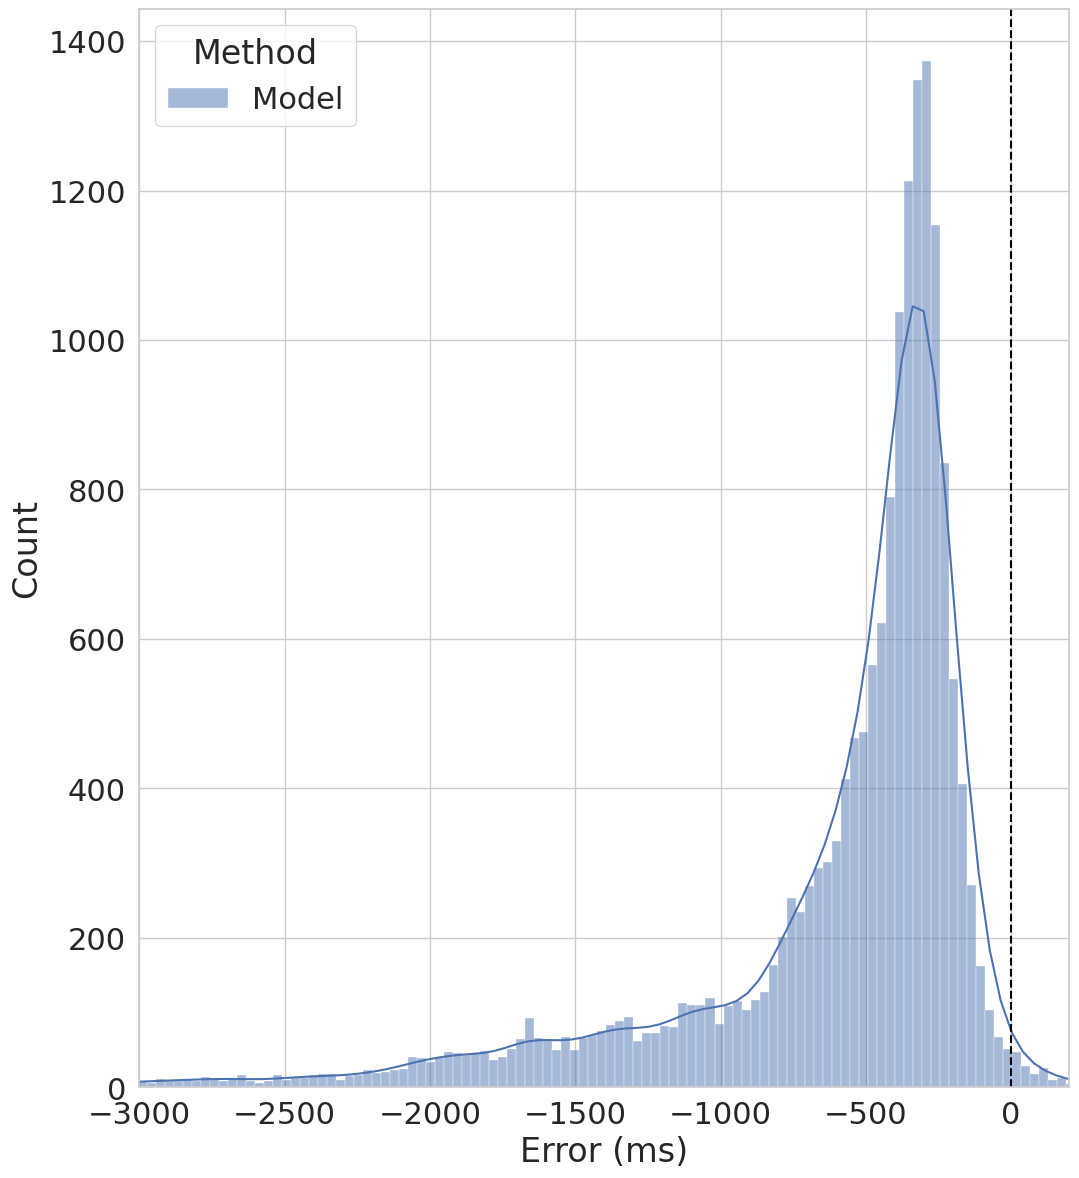

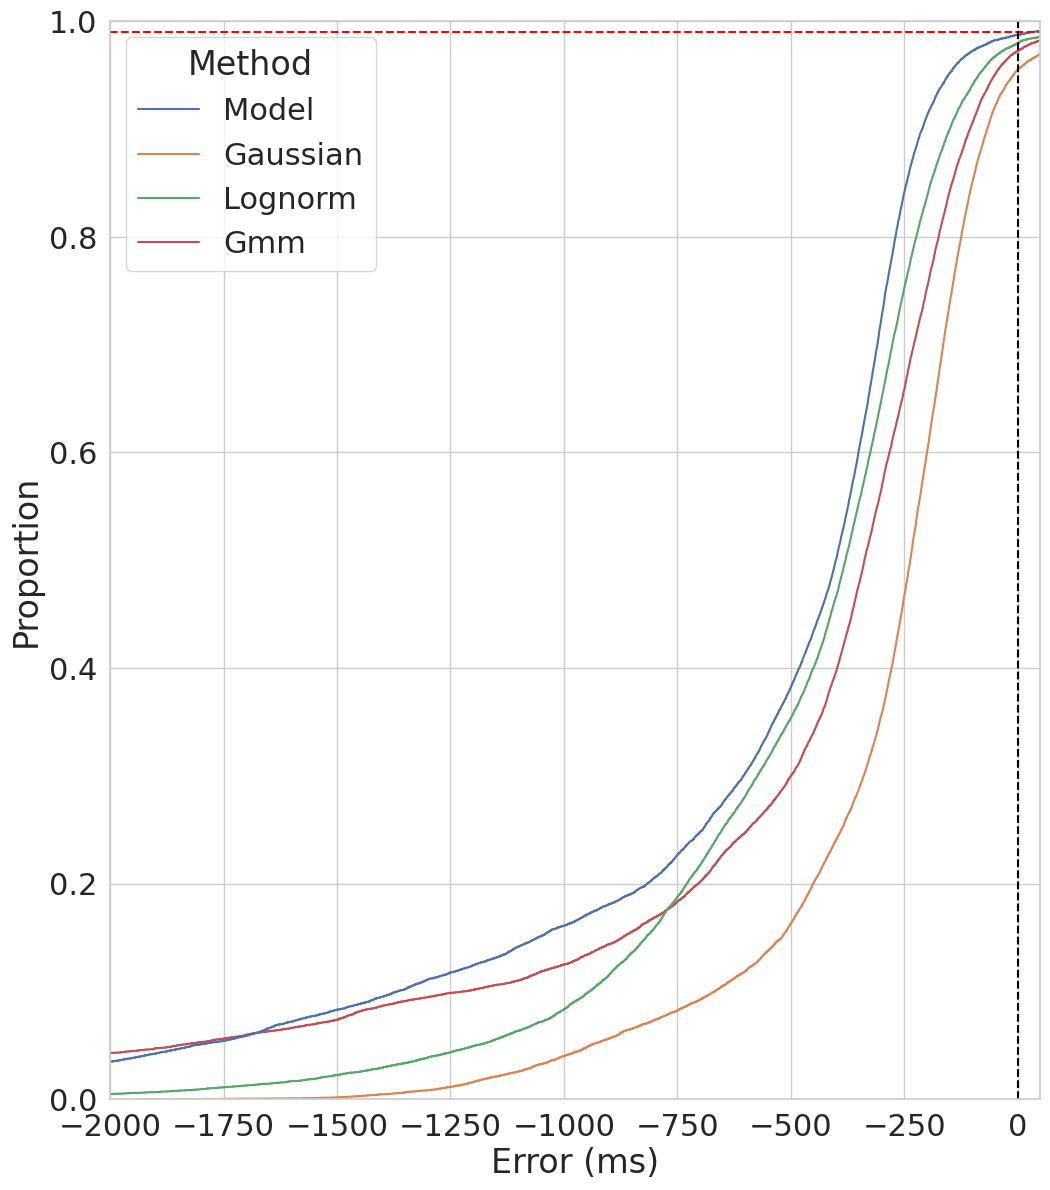

In [97]:
vis.err_distibution('m0_q99_err_dist.pdf', m0_q99[m0_q99['Method']=='Model'], (-3000, 200))
vis.ecdf('m0_q99_ecdf.pdf', m0_q99, 0.99, (-2000,50))

In [91]:
m0[['Latency']].describe()

,Latency
count,211200.000000
mean,115.541891
std,173.486869
min,1.946000
25%,32.071000
50%,70.249500
75%,137.180750
max,3737.491000


In [ ]:
calculate_mid_results([m0_naiv])